# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Define paths for train, valiate & test image sets
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
# train transform includes some augmentation steps
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

# Load the categories to names mappings into a dictionary
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# TODO: Build and train your network

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(torch.device)
#print(torch.cuda.current_device())
#print(torch.cuda.get_device_name())

#Load pre-trained model
model = models.densenet121(pretrained=True)

# Print model so can see size of classifier
display(model)

# Turn off gradients
for param in model.parameters():
    param.requires_grad = False

# Replace existing classifier with input layer (1024), hidden layer (512), output layer (102)
# Classifier input layer has 1024 nodes to match densenet classifier 
# Classifier output layer has 102 nodes because there are 102 classes in the cat_to_name.json file
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          # 1st hidden layer with relu activation and dropout
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.2)),

                          # output layer
                          ('fc2', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Add new classifier to slected model
model.classifier = classifier
#print(model)

# Set the criterion to Negative Log Likelihood Loss
criterion = nn.NLLLoss()

# Set the optimizer and learnign rate
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

# Move model to GPU if available
model.to(device);

C:\Users\neil_\anaconda3\envs\Pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neil_\anaconda3\envs\Pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
# Initialize training variables
epochs = 4
print_every = 20
steps = 0
running_loss = 0

In [7]:
# Train the model

for epoch in range(epochs):
    # training pass
    model.train()
    for inputs, labels in train_loader:
        steps += 1
        
        # Move input and label tensors to the device (GPU, or CPU if GPU not available)
        inputs, labels = inputs.to(device), labels.to(device)

        # clear gradients
        optimizer.zero_grad()
        
        # do the forward prop
        logps = model.forward(inputs)

        # calculate the loss
        loss = criterion(logps, labels)
        
        # do the backwards prop
        loss.backward()
        optimizer.step()

        # add training loss
        running_loss += loss.item()
        
        if steps % print_every == 0:
            with torch.no_grad():
                model.eval()
                validation_loss = 0
                accuracy = 0

                # validation pass
                for inputs, labels in valid_loader:
                    # Move input and label tensors to the device (GPU, or CPU if GPU not available)
                    inputs, labels = inputs.to(device), labels.to(device)
                
                    logps = model(inputs)
                    loss = criterion(logps, labels)
                    validation_loss += loss.item()

                    # calculate validation accuracy
                    ps = torch.exp(logps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    equality = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss / print_every:.3f}.. "
                  f"Validation loss: {validation_loss / len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy / len(valid_loader):.3f}")
            
            running_loss = 0
            model.train()

Epoch 1/4.. Train loss: 4.290.. Validation loss: 3.644.. Validation accuracy: 0.216
Epoch 1/4.. Train loss: 3.217.. Validation loss: 2.404.. Validation accuracy: 0.483
Epoch 1/4.. Train loss: 2.422.. Validation loss: 1.659.. Validation accuracy: 0.628
Epoch 1/4.. Train loss: 1.883.. Validation loss: 1.184.. Validation accuracy: 0.698
Epoch 1/4.. Train loss: 1.558.. Validation loss: 0.985.. Validation accuracy: 0.749
Epoch 2/4.. Train loss: 1.280.. Validation loss: 0.807.. Validation accuracy: 0.785
Epoch 2/4.. Train loss: 1.189.. Validation loss: 0.690.. Validation accuracy: 0.819
Epoch 2/4.. Train loss: 1.086.. Validation loss: 0.607.. Validation accuracy: 0.849
Epoch 2/4.. Train loss: 1.058.. Validation loss: 0.679.. Validation accuracy: 0.817
Epoch 2/4.. Train loss: 0.979.. Validation loss: 0.540.. Validation accuracy: 0.846
Epoch 3/4.. Train loss: 0.971.. Validation loss: 0.612.. Validation accuracy: 0.831
Epoch 3/4.. Train loss: 0.929.. Validation loss: 0.482.. Validation accuracy

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# Calculate accuracy on the test set
batch = 0

model.eval()
with torch.no_grad():
    # test pass
    for inputs, labels in test_loader:
        batch += 1
        accuracy = 0
        
        # Move input and label tensors to the device (GPU, or CPU if GPU not available)
        inputs, labels = inputs.to(device), labels.to(device)
                
        outputs = model(inputs)
        predicted = torch.exp(outputs)
        
        # calculate validation accuracy
        top_ps, top_class = predicted.topk(1, dim=1)
        equality = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equality.type(torch.FloatTensor))
        print(f"In batch {batch}, model accuracy is {accuracy*100:.1f}%")
        

In batch 1, model accuracy is 93.8%
In batch 2, model accuracy is 89.1%
In batch 3, model accuracy is 84.4%
In batch 4, model accuracy is 81.2%
In batch 5, model accuracy is 95.3%
In batch 6, model accuracy is 75.0%
In batch 7, model accuracy is 98.4%
In batch 8, model accuracy is 87.5%
In batch 9, model accuracy is 98.4%
In batch 10, model accuracy is 98.4%
In batch 11, model accuracy is 90.6%
In batch 12, model accuracy is 90.6%
In batch 13, model accuracy is 84.3%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [10]:
# Save the checkpoint 

# Grab the current date/time so we can build a unique checkpoint filename
from datetime import datetime
ts = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
checkpoint_filename = 'checkpoint_' + ts + '.pth'
print(checkpoint_filename)

# Save the mapping of flower labels to indexes to the model
model.class_to_idx = train_data.class_to_idx

checkpoint = {'architecture': 'densenet121',
              'classifier': model.classifier,
              'model_class_to_idx': model.class_to_idx,
              'epochs': epochs,
              'optimizer_state_dict': optimizer.state_dict(),
              'model_state_dict': model.state_dict()}

torch.save(checkpoint, checkpoint_filename)

checkpoint_2024-07-26_11-21-18.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint_file(filepath, device='cpu'):
    checkpoint = torch.load(filepath, map_location=device)
    model = getattr(models, checkpoint['architecture'])(pretrained=True)
    model.class_to_idx = checkpoint['model_class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [29]:
model = load_checkpoint_file('densenet121_checkpoint_2024-07-27_10-49-08.pth', device)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [9]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    with Image.open(image) as im:
        # find the shortest side
        if im.width < im.height:
            short = im.width
        else:
            short = im.height

        # determine ratio to resize to 256
        resize_ratio = 256 / short
        resized_height = int(im.height * resize_ratio)
        resized_width = int(im.width * resize_ratio)
        
        # resize the image
        im_resized = im.resize((resized_width, resized_height))
        
        # find coords of 224x224 crop box
        left = int((resized_width - 224) / 2)
        upper = int((resized_height - 224) / 2)
        right = left + 224
        lower = upper + 224
        
        # crop the image
        im_crop = im_resized.crop((left, upper, right, lower))
        
        # re-encode color channels as floats
        im_encoded = np.array(im_crop) / 255
        
        # normalize image for classification
        im_normalized = (im_encoded - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
        
        # re-order dimensions for Pytorch (3rd dimension goes first, then 1st and 2nd in order)
        im_reordered = im_normalized.transpose((2, 0, 1))

        return im_reordered

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [10]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    #image = image.numpy().transpose((1, 2, 0))
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<Axes: >

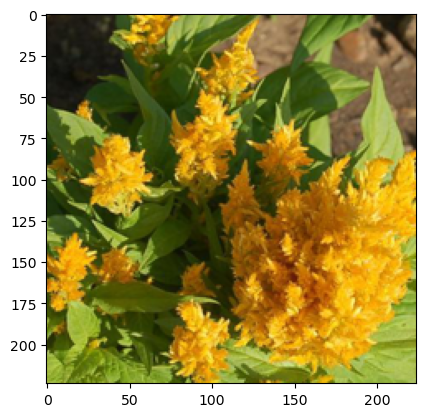

In [11]:
image_path = 'flowers/valid/27/image_06868.jpg'
flower = process_image(image_path)
imshow(flower)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [12]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

    # process image to be classified
    image_proc_np = process_image(image_path)
    #print(image_proc_np.shape)

    # resize numpy array
    image_proc_np = np.resize(image_proc_np, (1,3,224,224))

    # now convert numpy array to a tensor
    image_proc_tensor = torch.from_numpy(image_proc_np).type(torch.FloatTensor)

    
    # Move input to the device (GPU, or CPU if GPU not available)
    image_proc_tensor = image_proc_tensor.to(device)

    # move model to device (CPU or GPU)
    model.to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(image_proc_tensor)
        
    probabilities = torch.exp(outputs)
        
    # get the top k probabilities and class indexes
    top_ps, top_class = torch.topk(probabilities, dim=1, k=topk)

    # make tensors into numpy arrays
    top_ps, top_class = top_ps.to('cpu').numpy(), top_class.to('cpu').numpy()

    #make numpy arrays into lists, so can get class names from indexes
    top_ps, top_class = top_ps[0].tolist(), top_class[0].tolist()

    # use the index - class mapping to get the class for the top k indexes
    index_to_class = {idx: class_ for class_, idx in train_data.class_to_idx.items()}
    # reverse the mapping to get top k classes
    classes = [index_to_class[i] for i in top_class]

    return top_ps, classes
    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

[0.9990255832672119, 0.0006073554395698011, 8.88915456016548e-05, 6.784695142414421e-05, 5.971300561213866e-05]
['94', '79', '78', '88', '7']
['foxglove', 'toad lily', 'lotus lotus', 'cyclamen', 'moon orchid']


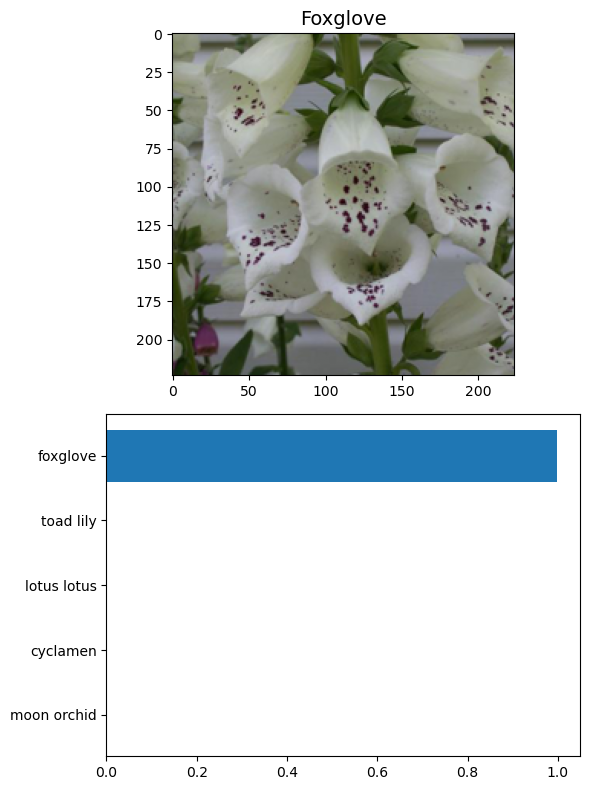

In [13]:
# TODO: Display an image along with the top 5 classes

# set path to flower image
test_flower_image = 'flowers/test/94/image_07361.jpg'

# set class for chosen flower image (from path above)
test_flower_class = '94'

# get the flower name from dict
flower_name = cat_to_name[test_flower_class]
#print(flower_name)

# now run the model and get top k (5) probablities and classes
probabilities, classes = predict(test_flower_image, model, topk=5)
print(probabilities)
print(classes)

# get top k flower names
flower_names_from_classes = [cat_to_name[i] for i in classes]
print(flower_names_from_classes)

#display the test flower image
#imshow(image=process_image(test_flower_image), ax=None, title=flower_name.title())

# Create figure and axes 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

# Render the flower image
imshow(image=process_image(test_flower_image), ax=ax1)

ax1.set_title(f'{flower_name.title()}', fontsize=14)

# Display top-k probabilities in horizontal barchart
index = np.arange(len(classes))[::-1]
ax2.barh(index, probabilities, tick_label=flower_names_from_classes, align='center')

# Plot the final figure
fig.tight_layout()